For the analysis I selected the following ETF, each of which tracking a corresponding index. 

-> SPY = tracking SP500

-> QQQ = tracking Nasdaq

-> DIA = tracking Dow Jones 

-> IWM = tracking Russel 2000

-> FEZ = tracking EUROSTOXX50

The choice of using ETFs for my analysis is due to the impossibility of fetching the whole indexes via TwelveData free API. Nonetheless, this choice represents a valid and feasible alternative due to the importance of the ETF, their fidelty to the indexes price variations, and their high liquidity, making them ideal trading instruments, especially for intraday movements.

In [10]:
import pandas as pd
from twelvedata import TDClient 
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
from scipy.stats import skew
td = TDClient(apikey="ce7c5d1412ff42d1a2ca90e47bd3105f")

In [11]:
ETFs=['SPY','QQQ','DIA','IWM','FEZ']

Following, a list of the main events that influenced the US elections, which I'll eventually highlight to see how they affected the market behaviour.

-> Trump attempted shooting : 2024-13-07

-> Biden resignment : 2024-21-07

-> Election date : 2024-05-11

Intraday election results ( GMT+1) : 

-> North Carolina results : 2024-06-11 05:20:00

-> Republicans win senate : 2024-06-11 06:14:00

-> Georgia results : 2024-06-11 06:42:00

-> Pennsylvania results : 2024-06-11 08:10:00

-> Winconsin results : 2024-06-11 11:36:00

-> Presidency victory : 2024-06-11 11:42:00

-> Michigan results : 2024-06-11 19:05:00

-> Xi Jinping congrats : 2024-07-11 04:06:00

In [37]:
# Define the list of events with corresponding date and time
events = {
    "2020-03-19": "First Statal Covid lockdown",
    "2020-11-03": "Joe Biden elected",
    "2021-01-06": "Capitol Hill riot",
    "2022-02-24": "Ukraine invasion",
    "2022-06-10": "inflation 40-year high",
    "2022-11-08": "Republicans win mid-term",
    "2023-03-10": "SVBank collapse",
    "2023-10-07": "Israel-Hamas conflict",
    "2024-05-01": "FED pauses rate hikes",
    "2024-07-13": "Trump attempted shooting",
    "2024-07-22": "Biden resignment",
    "2024-11-05": "Election date",
    "2024-11-06": "Election results",
    "2024-11-06 05:20:00": "North Carolina results",
    "2024-11-06 06:14:00": "Republicans win senate",
    "2024-11-06 06:42:00": "Georgia results",
    "2024-11-06 08:10:00": "Pennsylvania results",
    "2024-11-06 11:36:00": "Winconsin results",
    "2024-11-06 11:42:00": "Presidency victory",
    "2024-11-06 19:05:00": "Michigan results",
    "2024-11-07 04:06:00": "Xi Jinping congrats"
}


'''# Convert keys (dates) to datetime
events_dt = {datetime.strptime(date, "%Y-%m-%d %H:%M:%S") if " " in date else datetime.strptime(date, "%Y-%m-%d"): desc for date, desc in events.items()}

# Split into major events and intraday events
election_intraday = {k: v for k, v in events_dt.items() if k >= datetime(2024, 11, 6, 0, 0)}
election_majorevents = {k: v for k, v in events_dt.items() if k < datetime(2024, 11, 6, 0, 0)}'''

'# Convert keys (dates) to datetime\nevents_dt = {datetime.strptime(date, "%Y-%m-%d %H:%M:%S") if " " in date else datetime.strptime(date, "%Y-%m-%d"): desc for date, desc in events.items()}\n\n# Split into major events and intraday events\nelection_intraday = {k: v for k, v in events_dt.items() if k >= datetime(2024, 11, 6, 0, 0)}\nelection_majorevents = {k: v for k, v in events_dt.items() if k < datetime(2024, 11, 6, 0, 0)}'

In [13]:
events

{'2020-03-19': 'First Statal Covid lockdown',
 '2020-11-03': 'Joe Biden elected',
 '2021-01-06': 'Capitol Hill riot',
 '2021-03-11': 'American Rescue Plan Act',
 '2021-09-15': 'AUKUS announced ',
 '2022-02-24': 'Ukraine invasion',
 '2022-06-10': 'inflation 40-year high',
 '2022-11-08': 'Republicans win mid-term',
 '2023-03-10': 'SVBank collapse',
 '2023-06-06': 'SEC sues Binance and Coinbase',
 '2023-08-23': 'BRICS summit announces expansion',
 '2023-10-07': 'Israel-Hamas conflict',
 '2024-05-01': 'FED pauses rate hikes',
 '2024-07-13': 'Trump attempted shooting',
 '2024-07-21': 'Biden resignment',
 '2024-11-05': 'Election date',
 '2024-11-06': 'Election results',
 '2024-11-06 05:20:00': 'North Carolina results',
 '2024-11-06 06:14:00': 'Republicans win senate',
 '2024-11-06 06:42:00': 'Georgia results',
 '2024-11-06 08:10:00': 'Pennsylvania results',
 '2024-11-06 11:36:00': 'Winconsin results',
 '2024-11-06 11:42:00': 'Presidency victory',
 '2024-11-06 19:05:00': 'Michigan results',
 

In [14]:
#function to retrieve historical data for the given ticker  
def data_retrieval (ticker , frequency , startdate, enddate):
    ts = td.time_series(
    symbol=ticker,
    start_date=startdate, 
    end_date=enddate, 
    interval=frequency,
    outputsize=5000,
    timezone = 'Europe/Rome'
   
).as_pandas()
    return ts

In [101]:
def plot_datas(df, title, plotformat, interval, events=None, matching=None, start_date=None, end_date=None, trendline='moving_average', window=30, poly_degree=2):

    """
    This function plots stock data, including a trendline, and allows for the addition of custom events. 
    You can highlight specific events, filter data by date range, and choose between different trendlines.

    Arguments:
    df (pd.DataFrame): DataFrame with datetime index and 'close' column for stock prices.
    title (str): Title of the plot.
    plotformat (str): Time format for x-axis ticks ('hour', 'minute', 'month', 'day').
    interval (int): Interval for x-axis ticks.
    events (dict): A dictionary of events with dates as keys and descriptions as values.
    matching (str): 'Y' for exact matching of event dates, None for intervals.
    start_date (str): Start date to filter data (format: 'YYYY-MM-DD').
    end_date (str): End date to filter data (format: 'YYYY-MM-DD').
    trendline (str): Type of trendline to apply ('moving_average' or 'polynomial').
    window (int): Window size for the moving average (if trendline is 'moving_average').
    poly_degree (int): Degree of the polynomial fit (if trendline is 'polynomial').
    """
    
    # Ensure index is datetime
    df.index = pd.to_datetime(df.index)

    # Filter data based on date range
    if start_date:
        start_date = pd.to_datetime(start_date)
        df = df[df.index >= start_date]

    if end_date:
        end_date = pd.to_datetime(end_date)
        df = df[df.index <= end_date]

    xvalues = df.index
    yvalues = df['close']

    # Plot the basic stock data (close prices)
    plt.figure(figsize=(12, 6))
    plt.plot(xvalues, yvalues, label="Stock Price", color='blue')

    # Add trendline
    if trendline == 'moving_average':
        # Calculate and plot moving average
        ma = df['close'].rolling(window=window).mean()
        plt.plot(xvalues, ma, label=f"Moving Average (window={window})", color='orange', linestyle='--', linewidth=2)
    elif trendline == 'polynomial':
        # Fit a polynomial and plot
        x_numeric = (xvalues - xvalues[0]).total_seconds()  # Convert dates to numeric
        coefficients = np.polyfit(x_numeric, yvalues, poly_degree)
        poly_fit = np.poly1d(coefficients)
        y_fit = poly_fit(x_numeric)
        plt.plot(xvalues, y_fit, label=f"Polynomial Fit (degree={poly_degree})", color='green', linestyle='--', linewidth=2)

    # Handle highlighting logic
    if events:
        highlight = list(events.keys())
        if matching == 'Y':
            # Highlight exact dates in 'highlight'
            df_highlighted = df[df.index.isin(highlight)]
            plt.scatter(df_highlighted.index, df_highlighted['close'], color='red', label='Highlighted', zorder=2)
        else:
            # Check if highlight contains intervals or single dates
            if highlight and isinstance(highlight[0], tuple):
                # Highlight intervals
                for start, end in highlight:
                    start = pd.to_datetime(start)
                    end = pd.to_datetime(end)
                    df_highlighted = df[(df.index >= start) & (df.index <= end)]
                    plt.scatter(df_highlighted.index, df_highlighted['close'], color='red', label='Highlighted', zorder=2)
            else:
                # Highlight single dates
                df_highlighted = df[df.index.isin(highlight)]
                plt.scatter(df_highlighted.index, df_highlighted['close'], color='red', label='Highlighted', zorder=2)

    # Add annotations
    if events:
        for date, desc in events.items():
            date = pd.to_datetime(date)
            if date in df.index:
                y_pos = df.loc[date, 'close']
                plt.annotate(
                    desc,
                    xy=(date, y_pos),
                    xytext=(date, y_pos + (yvalues.max() - yvalues.min()) * 0.3),
                    arrowprops=dict(facecolor='black', arrowstyle='->'),
                    fontsize=8,
                    ha='center'
                )

    # Customize x-axis ticks
    ax = plt.gca()
    if plotformat == 'hour':
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=interval))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    elif plotformat == 'minute':
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=interval))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    elif plotformat == 'month':
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    elif plotformat == 'day':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.xaxis.set_minor_locator(mdates.YearLocator())
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Y'))
        for label in ax.get_xminorticklabels():
            label.set_fontsize(10)
            label.set_color('red')

    # Add title and labels
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Close Price')

    # Remove upper and right-side plot border
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Add legend and show the plot
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()

1) Percentage return 

2) Volatility = standard deviation 

3) Trading Volume = we could try normalize the trading volume and multiply the percentage return by (1+volume) -> including both would highlight the market movement --> let's use the VWIP

4) Correlation between stocks (the pretty table fabio did)

5)  Cumulated returns 

6) DIstribution of Returns -> calculate skewness 

In [20]:
def percentage_return(prices):
    """
    Calculate the percentage return for a list of prices.

    Parameters:
        prices (list): A list of prices.

    Returns:
        list: A list of percentage changes between consecutive prices.
              The first element is set to 0, representing no change.
    """
    if len(prices) < 2:
        raise ValueError("The list must contain at least two prices to calculate percentage changes.")

    # Calculate percentage changes
    returns = [0]  # Initial change is set to 0
    returns += [(prices[i] - prices[i - 1]) / prices[i - 1]  for i in range(1, len(prices))]
    return returns

In [48]:
def volatility (close):
    '''
    Calculate the volatility value for the given time range

    Parameters :
        pct_change (list or array): List of percentage returns for the given stock.
    '''
    return np.std(close, ddof=1)

In [22]:
def calculate_VWIP (prices , volume):
    """
    Calculate Volume-Weighted Average Price (VWAP).
    
    Parameters:
        prices (list or array): List of trade prices.
        volumes (list or array): List of trade volumes.

    Returns:
        float: The calculated VWAP.
    """
    if len(prices) != len(volume):
        raise ValueError("Prices and volumes must have the same length.")
    
    # Calculate VWAP
    vwap = sum(p * v for p, v in zip(prices, volume)) / sum(volume)
    return vwap

In [23]:
def calculate_cum_ret(pct_change):
    """
    Calculate cumulative returns for a list of prices.

    Parameters:
        prices (list): A list of prices.

    Returns:
        list: A list of cumulative returns at each point in time.
    """
    if len(pct_change) < 2:
        raise ValueError("The list must contain at least two prices to calculate cumulative returns.")

    # Calculate cumulative returns
    cum_returns = []
    cumulative_product = 1  # Start with a multiplicative identity
    for pct in pct_change:
        cumulative_product *= (1 + pct)
        cum_returns.append(cumulative_product - 1)  # Subtract 1 to represent net cumulative return

    # Add an initial zero return for the first price
    return [0] + cum_returns

In [24]:
def plot_density_distribution(pct_change):
    """
    Plot the density distribution of prices using a histogram and KDE.
    
    Parameters:
        prices (list): A list of prices.
    """
    plt.figure(figsize=(10, 6))

    skewness=skew(pct_change)
    print('The value of skewness of the dataset is',skewness,'\n\n')
    

    # Histogram
    sns.histplot(pct_change, kde=True, stat="density", bins=30, label="Histogram + KDE", color="skyblue")
    
    # Formatting
    plt.title("Density Distribution of Prices")
    plt.xlabel("Price")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    return

In [25]:
def correlation_matrix (dataframe):
    """
    Plot the correlation matrix for the given ETFs
    
    Parameters:
        dataframe (pandas.dataframe): A dataframe containing the percentage returns of the selected ETFs.
    """
    # Calculate Correlation Matrix
    corrmat = dataframe.corr()

    # Plot the Correlation Matrix as a Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corrmat, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
    plt.title("Correlation Matrix of Stock Percentage Changes")
    plt.show()
    return 

In [54]:
def average_volume(volume):
    """
    Calculate the average (mean) of the provided volume data.

    Args:
    - volume (pandas.Series): A pandas Series object containing numerical data, typically representing trading volume values.

    Returns:
    - float: The average of the values in the `volume` Series.
    """
    avg_volume = volume.mean()  # Using pandas' built-in mean method to calculate the average
    return avg_volume


Adesso devo selezionare i delta temporali più significativi 

-> mandato biden (evidenziando gli eventi più significativi) (daily, weekly)

-> 2024 - adesso (daily, weekly)

-> inizio elezioni - fine elezioni (minutely)

-> fine elezioni - adesso (hourly) 

In [26]:
#year-month-day
start_biden = '2020-01-01' #daily , weekly 
end_biden = '2024-11-01' #daily, weekly 
start_2024 = '2024-01-01' #daily
end_2024 = '2024-11-20' #daily 
start_election_1 = '2024-11-05 00:00:00' #minutely 
end_election_1 = '2024-11-06 00:00:00'  #minutely
start_election_2 = '2024-11-06 00:00:00' #minutely 
end_election_2 = '2024-11-07 00:00:00'  #minutely
start_aftermath = '2024-11-07 00:00:00'  #hourly 
end_aftermath = '2024-11-20 00:00:00'  #hourly

In [60]:
#let's retrieve all the datas
etf=ETFs[0]
etf_biden_d=data_retrieval(etf , '1day', start_biden , end_biden)
'''etf2_biden_d=data_retrieval(ETFs[1] , '1day', start_biden , end_biden)
etf3_biden_d=data_retrieval(ETFs[2] , '1day', start_biden , end_biden)
etf4_biden_d=data_retrieval(ETFs[3] , '1day', start_biden , end_biden)
etf5_biden_d=data_retrieval(ETFs[4] , '1day', start_biden , end_biden)'''

etf_biden_w = data_retrieval(etf, '1week', start_biden, end_biden )
etf_2024 = data_retrieval(etf, '1day', start_2024, end_2024)
etf_election_day1 = data_retrieval(etf, '1min', start_election_1, end_election_1)
etf_election_day2 = data_retrieval(etf, '1min', start_election_2, end_election_2)
etf_aftermath = data_retrieval(etf, '1day', start_aftermath, end_aftermath)

"etf_biden_w = data_retrieval(etf, '1week', start_biden, end_biden )\netf_2024 = data_retrieval(etf, '1day', start_2024, end_2024)\netf_election_day1 = data_retrieval(etf, '1min', start_election_1, end_election_1)\netf_election_day2 = data_retrieval(etf, '1min', start_election_2, end_election_2)\netf_aftermath = data_retrieval(etf, '1day', start_aftermath, end_aftermath)"

/var/folders/l4/ybqxqy391fx0g8rhn62_7n1h0000gn/T/ipykernel_7929/3182796935.py:71: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



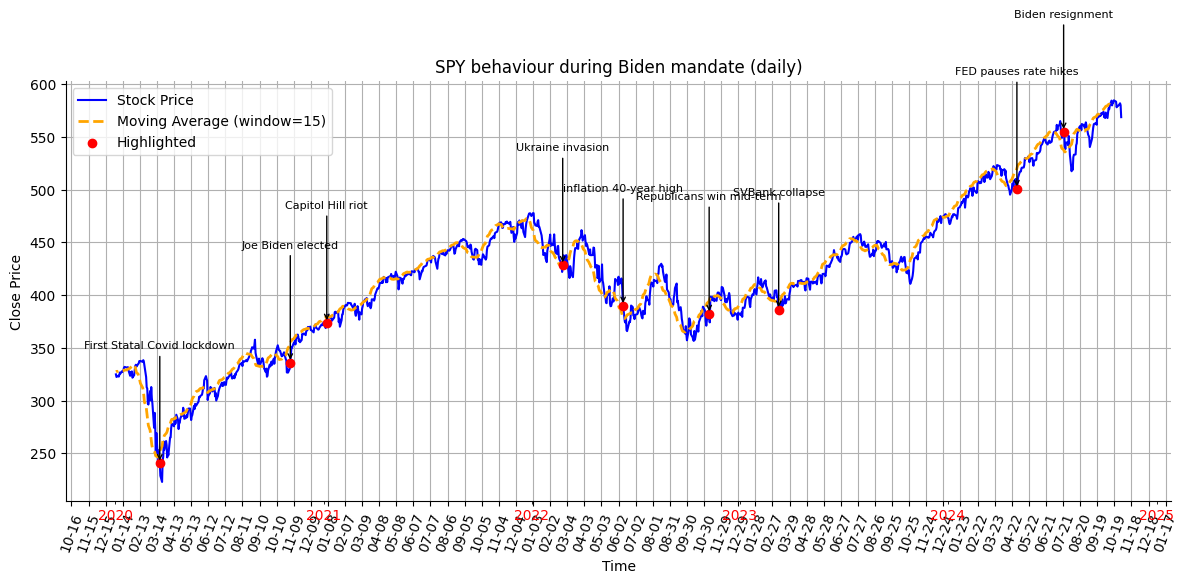

"plot_datas(etf2_biden_d, 'QQQ behaviour during Biden mandate (daily)','day',interval=30, events=events, window=15)\nplot_datas(etf3_biden_d, 'DIA behaviour during Biden mandate (daily)','day',interval=30, events=events, window=15)\nplot_datas(etf4_biden_d, 'IWM behaviour during Biden mandate (daily)','day',interval=30, events=events, window=15)\nplot_datas(etf5_biden_d, 'FEZ behaviour during Biden mandate (daily)','day',interval=30, events=events, window=15)"

In [102]:
plot_datas(etf_biden_d, 'SPY behaviour during Biden mandate (daily)','day',interval=30, events=events, window=15)
'''plot_datas(etf2_biden_d, 'QQQ behaviour during Biden mandate (daily)','day',interval=30, events=events, window=15)
plot_datas(etf3_biden_d, 'DIA behaviour during Biden mandate (daily)','day',interval=30, events=events, window=15)
plot_datas(etf4_biden_d, 'IWM behaviour during Biden mandate (daily)','day',interval=30, events=events, window=15)
plot_datas(etf5_biden_d, 'FEZ behaviour during Biden mandate (daily)','day',interval=30, events=events, window=15)'''

/var/folders/l4/ybqxqy391fx0g8rhn62_7n1h0000gn/T/ipykernel_7929/4081328214.py:62: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



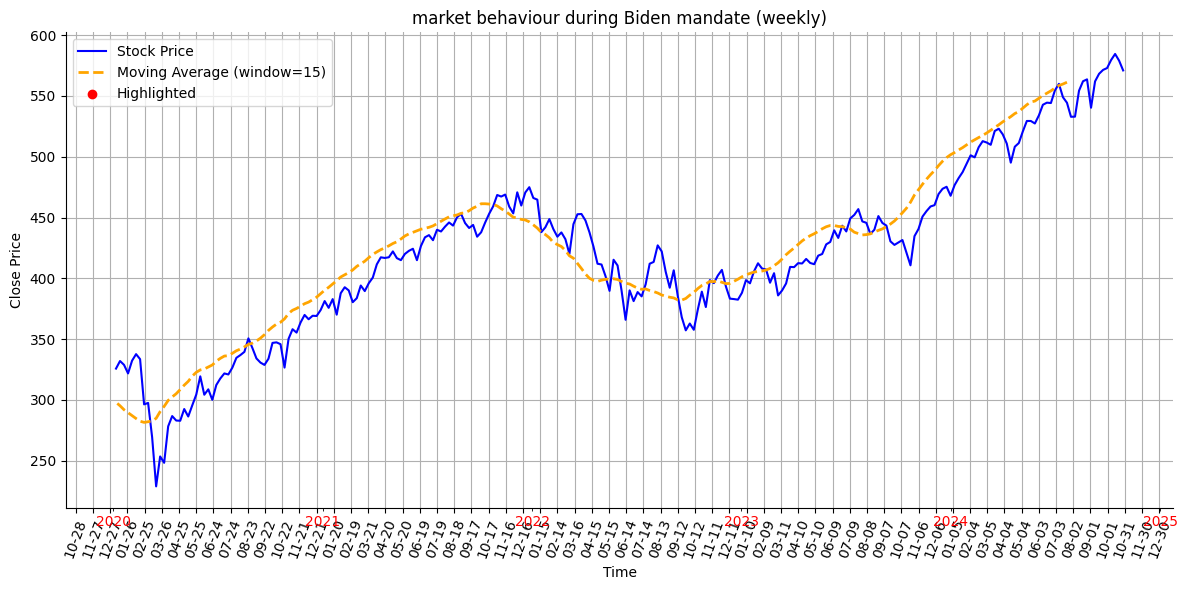

In [31]:
plot_datas(etf_biden_w, 'market behaviour during Biden mandate (weekly)','day',30,events,window=15)


/var/folders/l4/ybqxqy391fx0g8rhn62_7n1h0000gn/T/ipykernel_7929/4081328214.py:62: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



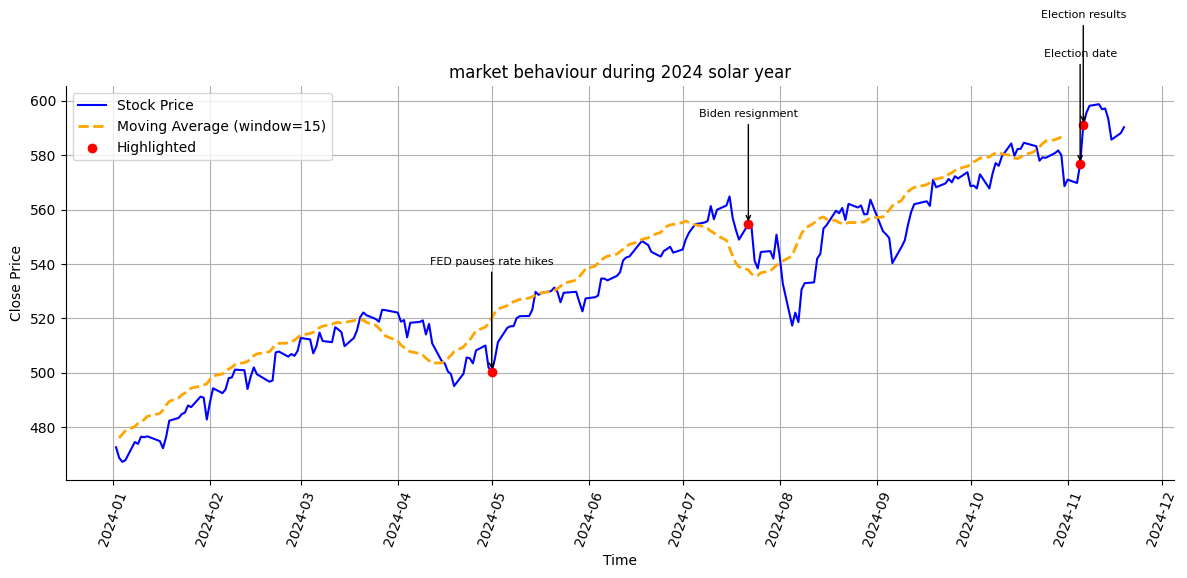

In [38]:
plot_datas(etf_2024, 'market behaviour during 2024 solar year', plotformat='month', interval=1, events=events, window=15)

/var/folders/l4/ybqxqy391fx0g8rhn62_7n1h0000gn/T/ipykernel_7929/4081328214.py:62: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



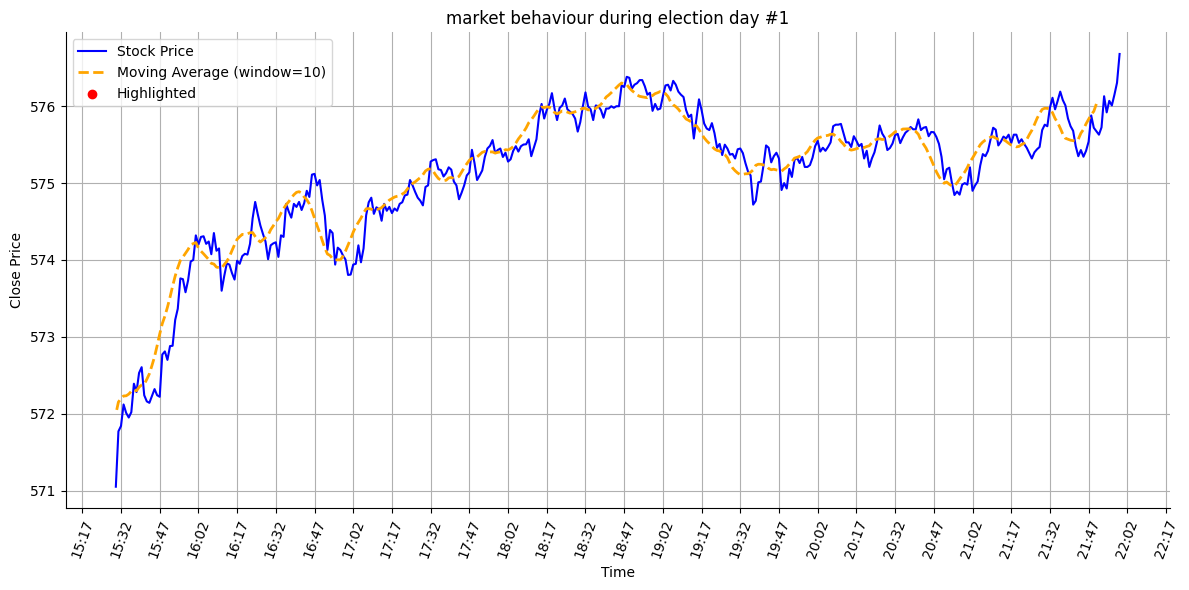

/var/folders/l4/ybqxqy391fx0g8rhn62_7n1h0000gn/T/ipykernel_7929/4081328214.py:62: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



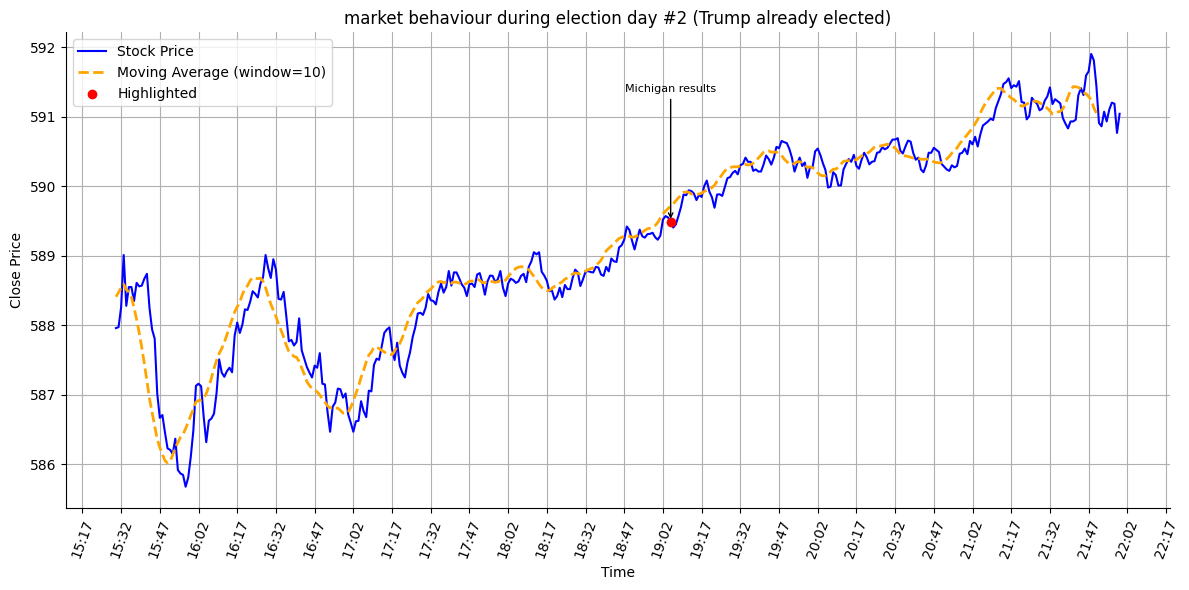

In [39]:
plot_datas(etf_election_day1, 'market behaviour during election day #1', 'minute', interval=15 , events=events, window=10 )
plot_datas(etf_election_day2, 'market behaviour during election day #2 (Trump already elected)', 'minute', interval=15 , events=events, window=10 )

/var/folders/l4/ybqxqy391fx0g8rhn62_7n1h0000gn/T/ipykernel_7929/4081328214.py:62: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



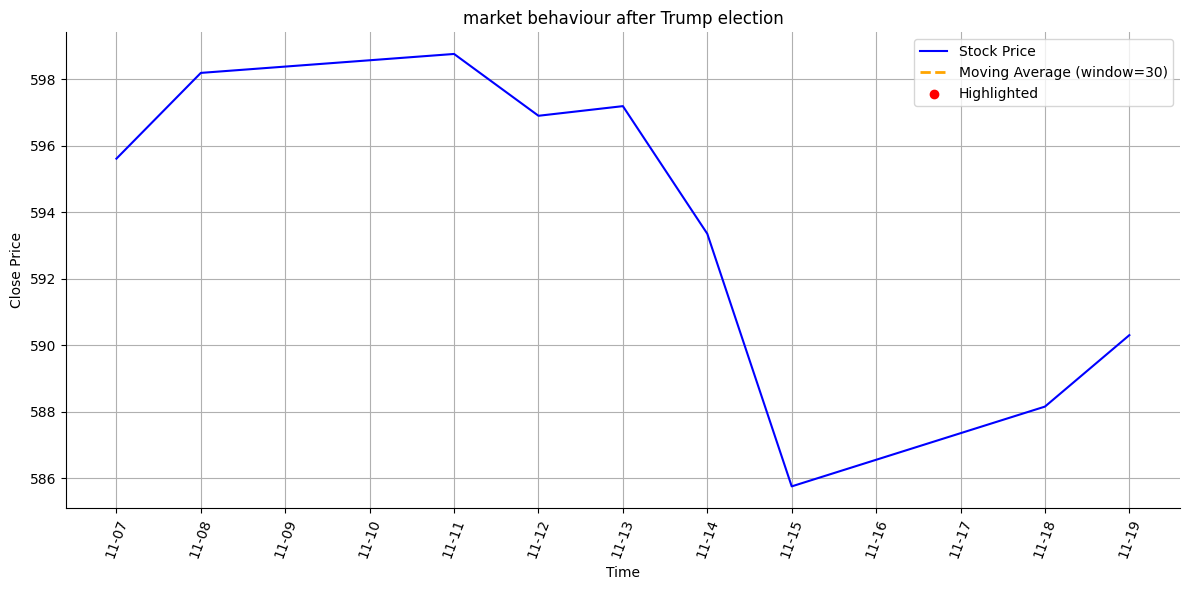

In [36]:
plot_datas(etf_aftermath, 'market behaviour after Trump election', plotformat='day', interval=1, events=events)

-----

Plotting density distribution of returns in percentage, skewness and volatility 

The value of skewness of the dataset is 1.0777814856597865 




/var/folders/l4/ybqxqy391fx0g8rhn62_7n1h0000gn/T/ipykernel_7929/3964030888.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



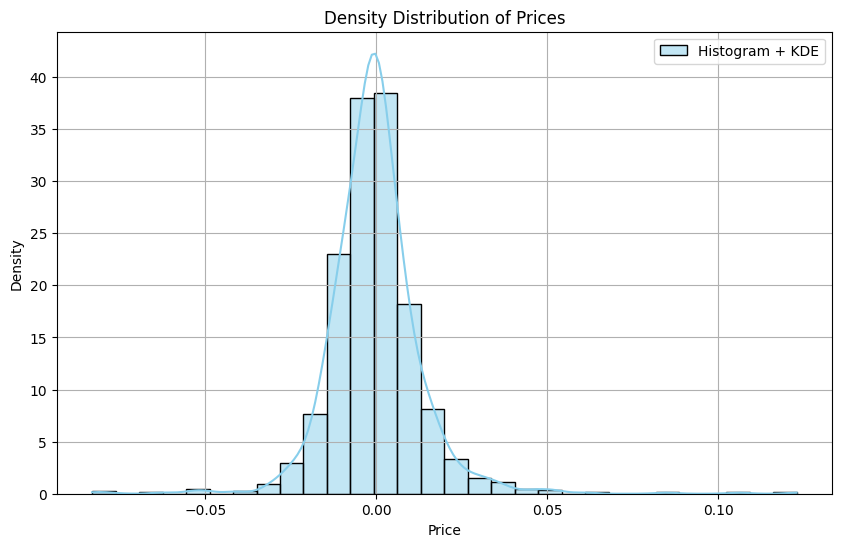

The volatility has been of  70.90665962976243


In [49]:
etf_biden_d_pct=percentage_return(etf_biden_d.close)
plot_density_distribution(etf_biden_d_pct)

etf_biden_d_volatility = volatility(etf_biden_d.close)
print('The volatility has been of ',etf_biden_d_volatility)

etf_biden_d_volume = average_volume(etf_biden_d.volume)
print('\nThe average volume has been of ',etf_biden_d_volume)



The value of skewness of the dataset is 1.201868811481438 




/var/folders/l4/ybqxqy391fx0g8rhn62_7n1h0000gn/T/ipykernel_7929/3964030888.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



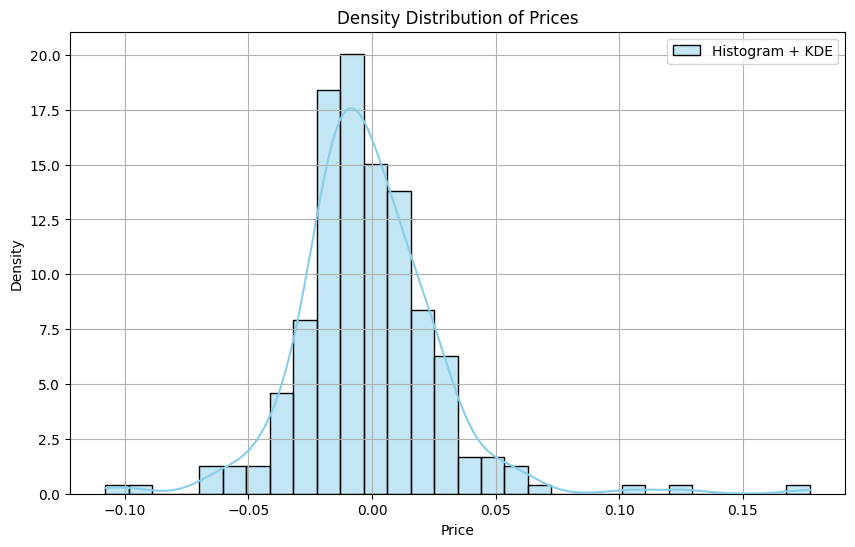

The volatility has been of  71.19656060422322

The average volume has been of  399462983.3333333


In [55]:
etf_biden_w_pct=percentage_return(etf_biden_w.close)
plot_density_distribution(etf_biden_w_pct)

etf_biden_w_volatility = volatility(etf_biden_w.close)
print('The volatility has been of ',etf_biden_w_volatility)

etf_biden_w_volume = average_volume(etf_biden_w.volume)
print('\nThe average volume has been of ',etf_biden_w_volume)

The value of skewness of the dataset is 0.44183398755220116 




/var/folders/l4/ybqxqy391fx0g8rhn62_7n1h0000gn/T/ipykernel_7929/3964030888.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



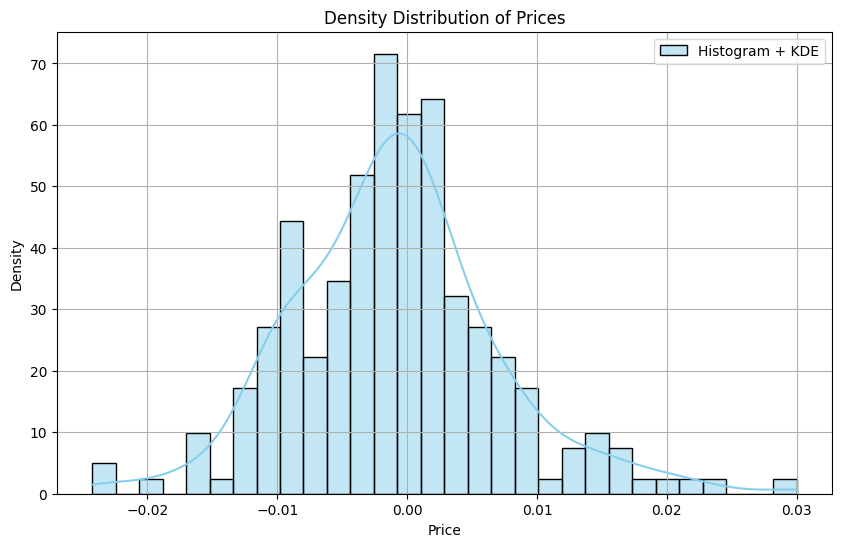

The volatility has been of  32.37429005712021

The average volume has been of  58577200.0


In [56]:
etf_2024_pct=percentage_return(etf_2024.close)
plot_density_distribution(etf_2024_pct)

etf_2024_volatility = volatility(etf_2024.close)
print('The volatility has been of ',etf_2024_volatility)

etf_2024_volume = average_volume(etf_2024.volume)
print('\nThe average volume has been of ',etf_2024_volume)



The value of skewness of the dataset is -0.28943592335843166 




/var/folders/l4/ybqxqy391fx0g8rhn62_7n1h0000gn/T/ipykernel_7929/3964030888.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



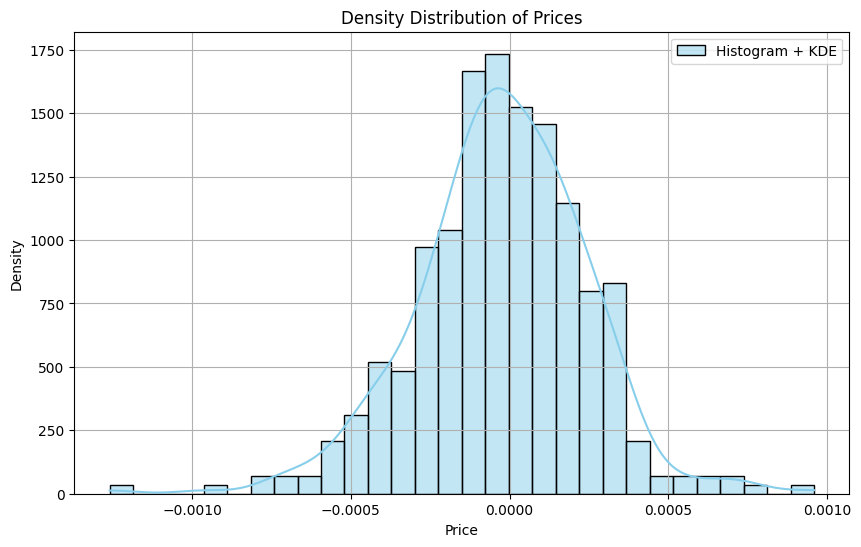

The volatility has been of  0.9656793018477613


In [52]:
etf_election_day1_pct=percentage_return(etf_election_day1.close)
plot_density_distribution(etf_election_day1_pct)

etf_election_day1_volatility = volatility(etf_election_day1.close)
print('The volatility has been of ',etf_election_day1_volatility)

etf_election_day1_volume = average_volume(etf_election_day1.volume)
print('\nThe average volume has been of ',etf_election_day1_volume)

The value of skewness of the dataset is 0.36927633520319314 




/var/folders/l4/ybqxqy391fx0g8rhn62_7n1h0000gn/T/ipykernel_7929/3964030888.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



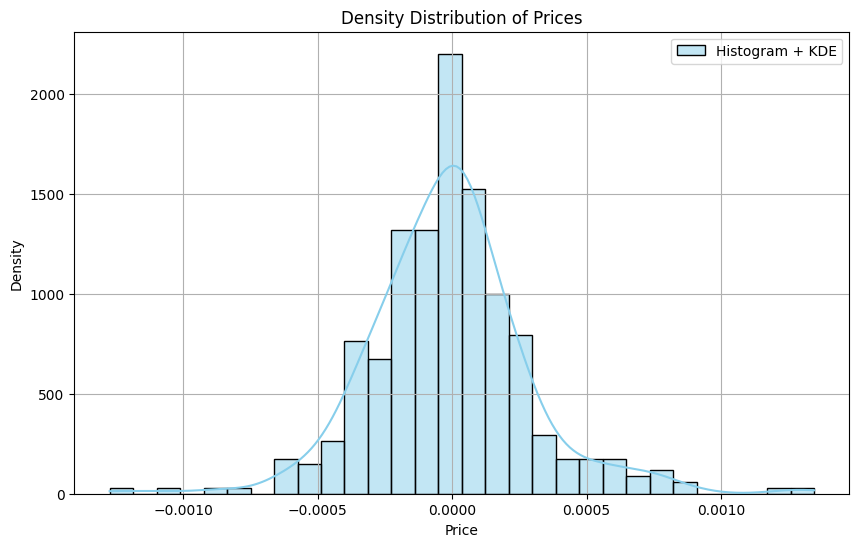

The volatility has been of  1.4519393261752993

The average volume has been of  151743.4358974359


In [57]:
etf_election_day2_pct=percentage_return(etf_election_day2.close)
plot_density_distribution(etf_election_day2_pct)

etf_election_day2_volatility = volatility(etf_election_day2.close)
print('The volatility has been of ',etf_election_day2_volatility)

etf_election_day2_volume = average_volume(etf_election_day2.volume)
print('\nThe average volume has been of ',etf_election_day2_volume)

-----

INCOMPLETE


Now let's plot the daily trading graph with vwap bands 

In [103]:
#need to be adjusted with the correct values for the volatility factor calculator


def plot_vwap(time, prices, volumes, interval):
    cumulative_price_volume = 0
    cumulative_volume = 0
    vwap_values = []
    volatility_factor=volatility(percentage_return(prices))
    print(volatility_factor)

    for price, volume in zip(prices, volumes):
        cumulative_price_volume += price * volume
        cumulative_volume += volume
        if cumulative_volume == 0:
            vwap_values.append(None)  # Avoid division by zero
        else:
            vwap_values.append(cumulative_price_volume / cumulative_volume)
    
    # Create upper and lower VWAP bands based on volatility_factor
    upper_band = [vwap *(1 + volatility_factor) for vwap in vwap_values]
    lower_band = [vwap *(1 - volatility_factor) for vwap in vwap_values]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set the x-axis locator and formatter for time intervals
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Plot Price and VWAP
    ax.plot(time, prices, color='red', label='Price', linewidth=2)
    ax.plot(time, vwap_values, color='lightblue', label='VWAP', linewidth=2)
    
    # Plot the upper and lower bands (shaded area between them)
    ax.fill_between(time, lower_band, upper_band, color='lightgreen', alpha=0.3, label='VWAP Bands')

    # Title and labels
    ax.set_title('Price vs VWAP with Bands')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price / VWAP')
    
    # Rotate x-axis labels to make them readable
    plt.xticks(rotation=45)
    
    # Show the legend
    ax.legend()
    
    # Display the plot
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

/var/folders/l4/ybqxqy391fx0g8rhn62_7n1h0000gn/T/ipykernel_7929/3964030888.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



0.0002674207422105894


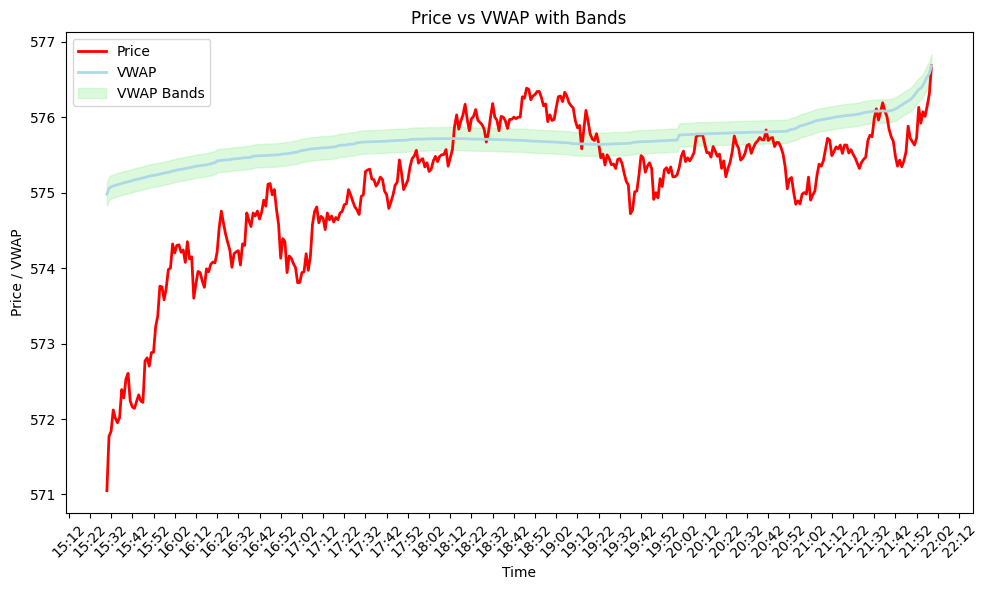

In [100]:
plot_vwap(etf_election_day1.index, etf_election_day1.close, etf_election_day1.volume, 10)